## Assignment 3
Finding fast growing firms

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *
warnings.filterwarnings("ignore")

### Import data

In [2]:
current_path = os.getcwd()
dirname = current_path.split("Code")[0]
Data = dirname + "\\Data"
output = dirname + "\\Output"

In [3]:
# Import data
data = pd.read_csv(Data + "\\cs_bisnode_panel.csv")

In [4]:
data.shape

(287829, 48)

In [5]:
#data.describe()

In [6]:
#data.isna().sum()

In [7]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)
data = data.query("year>2009&year<2016")

In [8]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

### Label engineering 

#### Dropping firms defaulting next year or this year.  

In [9]:
data = data.sort_values(by=["comp_id","year"])

In [10]:
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)
# defaults in one year if there are sales in this year but no sales 1 year later
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [11]:
data = data.query("status_alive == 1& default==0")

### Measuring fast growing companies
I will measure them based on sales growth in 1 year: Log sales change from 2012 to 2013. Further I classify top 15 percent sales increased firms as fast growing firms

In [12]:
data["sales"].describe()

count    1.208520e+05
mean     5.821963e+05
std      4.005378e+06
min      3.703704e+00
25%      1.640370e+04
50%      4.910370e+04
75%      1.571287e+05
max      1.110294e+08
Name: sales, dtype: float64

In [13]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

In [14]:
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")

<AxesSubplot:>

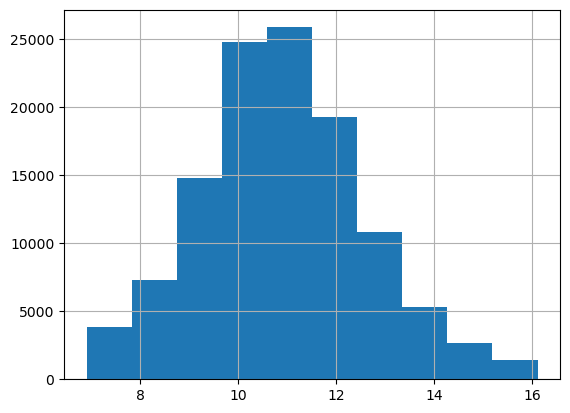

In [15]:
data.ln_sales.hist()

In [16]:
data["Sales_growth"] = data["ln_sales"] - data.groupby("comp_id")[
    "ln_sales"
].shift(1)

In [17]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["Sales_growth"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["Sales_growth"])
)
data["new"] = np.where(data["Sales_growth"].isna(), 1, data["new"])
data["Sales_growth"] = np.where(
    data["Sales_growth"].isna(), 0, data["Sales_growth"]
)

In [18]:
data["new"].describe()

count    116074.000000
mean          0.344582
std           0.475234
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

<AxesSubplot:>

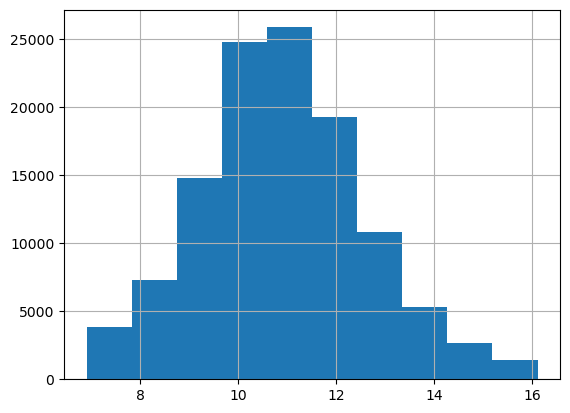

In [19]:
data.ln_sales.hist()

In [20]:
data["Sales_growth_target"] = data.groupby("comp_id")["Sales_growth"].shift(-1)

In [21]:
# look at cross section without new entrants 
data = data.query("year == 2012")


<AxesSubplot:>

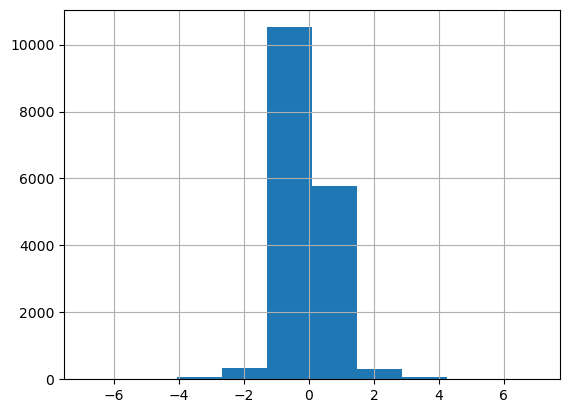

In [22]:
data["Sales_growth_target"].hist()

In [23]:
data["Sales_growth_target"].describe()

count    17095.000000
mean         0.043518
std          0.635991
min         -6.848888
25%         -0.131898
50%          0.000000
75%          0.205151
max          7.037021
Name: Sales_growth_target, dtype: float64

In [24]:
data["High_growth"] = np.where(data["Sales_growth_target"]>=data["Sales_growth_target"].quantile(0.85), 1,0)
#data["High_growth_2"] = np.where(data["Sales_growth_target"]>=data["Sales_growth_target"].mean(), 1,0)

In [25]:
data["Sales_growth_target"].quantile(0.85)

0.38731571899063116

In [26]:
data["High_growth"].value_counts()

0    16569
1     2565
Name: High_growth, dtype: int64

In [27]:
data.to_csv(output + "\\With_target.csv", index=False)

In [28]:
current_csv_path = os.path.join(output, "With_target.csv")
data = pd.read_csv(current_csv_path)

### Feature engineering 

In [29]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [30]:
data.groupby("ind2_cat").count()["comp_id"]

ind2_cat
20.0       50
26.0     1010
27.0      610
28.0     1842
29.0      259
30.0      159
32.0      134
33.0     1817
40.0      195
55.0     2081
56.0    10757
60.0      215
99.0        5
Name: comp_id, dtype: int64

In [31]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [32]:
# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    19119
1.0       10
Name: comp_id, dtype: int64

In [33]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [34]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.912900e+04
mean     2.776525e+05
std      1.465994e+06
min      0.000000e+00
25%      7.866667e+03
50%      2.776667e+04
75%      1.086000e+05
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [35]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [36]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [37]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [38]:
# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [39]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [40]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [41]:
# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [42]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [43]:
data["labor_avg"].describe()

count    16423.000000
mean         0.660444
std          1.662429
min          0.083333
25%          0.104167
50%          0.243056
75%          0.548611
max         42.118057
Name: labor_avg, dtype: float64

In [44]:
data["labor_avg_mod"].describe()

count    19134.000000
mean         0.660444
std          1.540156
min          0.083333
25%          0.131944
50%          0.305556
75%          0.660444
max         42.118057
Name: labor_avg_mod, dtype: float64

In [45]:
data = data.drop(["labor_avg"], axis=1)

In [46]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")

In [47]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()

count    16822.00000
mean         9.02681
std          6.95873
min          0.00000
25%          3.00000
50%          8.00000
75%         15.00000
max         32.00000
Name: age, dtype: float64

In [48]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

In [49]:
data.to_csv(output + "\\bisnode_firms_clean.csv", index=False)

In [50]:
data.High_growth.value_counts()

0    14482
1     2340
Name: High_growth, dtype: int64

In [51]:
data['Sales_growth_target'].mean()

0.04460713866559084

In [52]:
data.groupby('High_growth')['Sales_growth_target'].mean()

High_growth
0   -0.122144
1    0.951119
Name: Sales_growth_target, dtype: float64